# Endorsements and reactions - Retweets and Quoted tweets 

Plausible assumptions from existing research:
1. **Retweets** are **endorsements** 
2. **Quoted tweets** are **reactions** - can be positive, negative or neutral 

### [Table of Contents](#cell2)

* 1\. [Distribution of retweets, replies and quoted tweets](#cell1)
* 2\. [Foreign influence: Inferring the influential countries](#cell2)
* 3\. [Bursty tweets: Inferring tweets with high intensity of extreme sentiments](#cell3)
    * 3.1. [Inferring viral quoted tweets](#cell31)
    * 3.2. [Sentiment analysis of the viral quoted tweets](#cell32)
    * 3.3. [Inferring viral quoted tweets with extreme intensity of sentiments](#cell33)
* 4\. [Viral local retweets: Local news feed](#cell4)
    * 4.1. [Viral local retweets with negative sentiment](#cell41)
    * 4.2. [Viral local retweets with positive sentiment](#cell42)
<!--     * 4.3. [Viral local retweets with all sentiments (general)](#cell43) -->
* 5\. [Viral global retweets: Global news feed](#cell5)
    * 5.1. [Viral global retweets with negative sentiment](#cell51)
    * 5.2. [Viral global retweets with positive sentiment](#cell52)
<!--     * 5.3. [Viral global retweets with all sentiments (general)](#cell53) -->

In [1]:
import re
import os
import time
import glob 
from datetime import datetime  as dt

import collections as col
import functools as ft
import itertools as it

import numpy as np
import pandas as pd

# visualizations
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_colwidth', None)

In [11]:
DATA_PATH = '../data/singapore/'



##### Loading the processed Singapore-based data 

In [12]:
tweets = pd.read_csv(DATA_PATH + "singapore_tweets.csv")
tweets.shape

(109388, 54)

In [13]:
tweets.columns

Index(['Unnamed: 0', 'tweet_text', 'tweet_time', 'tweet_id', 'tweet_lang',
       'tweet_possibly_sensitive', 'entity_image_url', 'entity_mentions',
       'entity_hashtags', 'entity_link_url', 'user_id_x', 'user_name_x',
       'user_screenname_x', 'user_friends_count', 'user_followers_count',
       'user_verified', 'user_location', 'user_desc', 'user_geo_coding',
       'user_geo_tagging', 'user_id_y', 'user_name_y', 'user_screenname_y',
       'tweet_enagagement_type', 'replied_to_tweet_id', 'replied_to_user_id',
       'replied_to_user_screenname', 'retweeted_tweet_id',
       'retweeted_tweet_time', 'retweeted_user_id', 'retweeted_user_name',
       'retweeted_user_verified', 'retweeted_user_screenname',
       'retweeted_user_geo_coding', 'retweeted_user_geo_coding_type',
       'retweeted_retweet_count', 'retweeted_favorite_count',
       'quoted_tweet_text', 'quoted_tweet_id', 'quoted_tweet_time',
       'quoted_user_id', 'quoted_user_name', 'quoted_user_verified',
       'quo

In [14]:
MAX_DATE = tweets['tweet_date'].max()
MIN_DATE = tweets['tweet_date'].min()
MIN_DATE, MAX_DATE

('2021-08-04', '2021-09-23')

# 1. Distribution of retweets, replies and quoted tweets  <a id="cell1"></a>

In [15]:
tweet_enagagement_type = tweets[tweets['tweet_enagagement_type'].notna()]

print("Count of engaged tweets {}".format(len(tweet_enagagement_type)))
print("% of engaged tweets {}".format(len(tweet_enagagement_type)/len(tweets)*100))

Count of engaged tweets 69171
% of engaged tweets 63.234541265952394


In [16]:
count_tweet_enagagement_type = col.Counter(tweet_enagagement_type['tweet_enagagement_type']).most_common()
count_tweet_enagagement_type

[('Retweet', 34476), ('Quote', 24682), ('Reply', 10013)]

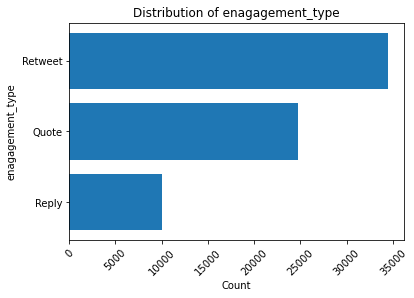

In [17]:
enagagement_type = [c[0] for c in count_tweet_enagagement_type]
counts = [c[1] for c in count_tweet_enagagement_type]

plt.barh(enagagement_type[::-1], counts[::-1])
 
plt.ylabel("enagagement_type")
plt.xlabel("Count")
plt.xticks(rotation=45)
plt.title("Distribution of enagagement_type")
plt.show()

In [18]:
# constants
COUNTRY = 'Singapore'
TOP_RTS_POS_NEG = 5

# 2. Foreign influence: Inferring the influential countries <a id="cell2"></a>

**Influential countries**: Tweets by non-Singapore based users with a high number of engagements - retweets and quoted tweets, by Singapore users. 

In [19]:
countries_data = pd.read_csv(DATA_PATH + "countries_geolocation.csv")

SINGAPORE_LONG_LAT = countries_data[countries_data['Country'] == 'Singapore']

sg_long = float(SINGAPORE_LONG_LAT.iloc[0]['Longitude (average)'].strip().strip('"'))  #.iloc(0)['Longitude (average)']
sg_lat = float(SINGAPORE_LONG_LAT.iloc[0]['Latitude (average)'].strip().strip('"'))

sg_long, sg_lat

FileNotFoundError: [Errno 2] No such file or directory: '../data/singapore/countries_geolocation.csv'

In [34]:
def plot_top_influential_countries(c_quoted_rts_geo):
    x_top = 10
    quoted_rts_geo = [c[0] for c in c_quoted_rts_geo[:x_top]]
    quoted_rts_geo_count = [c[1] for c in c_quoted_rts_geo[:x_top]]

    plt.barh(quoted_rts_geo[::-1], quoted_rts_geo_count[::-1])

    plt.ylabel("rts_quoted_geo")
    plt.xlabel("Count")
    plt.xticks(rotation=45)
    plt.title("Distribution of retweeted & quoted users' location")
    plt.show()


def get_top_influential_countries(top_countries_count=10):
    # Selecting tweets created by non-Singapore based users and known geocoding.  
    quoted_tweets = tweets[(tweets['tweet_enagagement_type'] == 'Quote') & 
                             (tweets['quoted_user_geo_coding'] != 'Unknown') & 
                            (tweets['quoted_user_geo_coding'] != 'Singapore')]

    rts_tweets = tweets[(tweets['tweet_enagagement_type'] == 'Retweet') & 
                              (tweets['retweeted_user_geo_coding'] != 'Unknown') & 
                              (tweets['retweeted_user_geo_coding'] != 'Singapore')]

    quoted_rts_geo = list(quoted_tweets['quoted_user_geo_coding']) + \
                    list(rts_tweets['retweeted_user_geo_coding'])
    c_quoted_rts_geo = col.Counter(quoted_rts_geo).most_common()
    plot_top_influential_countries(c_quoted_rts_geo)
    return c_quoted_rts_geo[:top_countries_count]

##### Loading data containing counties' geolocation and code

In [35]:
def generate_dash_influential_countries(top_country_influencer, top_country_influencer_csv_path):
    top_influential_countries_data = {
        'country': [],
        'lat': [],
        'long': [],
        'count': [],
        'size': []
    }

    sum_influence = sum([c[1] for c in top_country_influencer])

    for i in top_country_influencer:
        top_influential_countries_data['country'].append(i[0])
        top_influential_countries_data['count'].append(i[1])
        top_influential_countries_data['size'].append(round(i[1]/sum_influence*150, 2))
        country_loc = countries_data[countries_data['Country'] == i[0]]
        top_influential_countries_data['long'].append(float(country_loc.iloc[0]['Longitude (average)'].strip().strip('"')))
        top_influential_countries_data['lat'].append(float(country_loc.iloc[0]['Latitude (average)'].strip().strip('"')))

    top_influential_countries_df = pd.DataFrame(top_influential_countries_data)
    pd.DataFrame.to_csv(top_influential_countries_df, top_country_influencer_csv_path)
    return top_influential_countries_df

In [36]:
def generate_dash_influential_countries_tweets(top_influential_countries_df, top_country_influencer_tweets_csv_path):
    top_influential_countries = top_influential_countries_df['country']
    top_countries_tweets = tweets[(tweets['retweeted_user_geo_coding'].isin(top_influential_countries))
                                    & (tweets['processed_tweet_text'].notna())] \
                            [['retweeted_user_geo_coding', 'processed_tweet_text']]
    pd.DataFrame.to_csv(top_countries_tweets, top_country_influencer_tweets_csv_path)

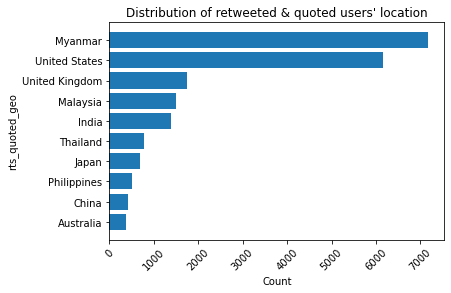

NameError: name 'countries_data' is not defined

In [37]:
top_country_influencer_csv_path = DATA_PATH + 'output/influencers/top_countries.csv'
top_country_influencer_tweets_csv_path = DATA_PATH + 'output/influencers/top_countries_tweets.csv'

top_country_influencer = get_top_influential_countries()
top_influential_countries_df = generate_dash_influential_countries(top_country_influencer, top_country_influencer_csv_path)

# Saving tweets from the top influential countries for word frequencies analysis 
generate_dash_influential_countries_tweets(top_influential_countries_df, top_country_influencer_tweets_csv_path)

# Engagements Analysis

In [38]:
PERCENTILE = .90
TOP_RTS_POS_NEG = 10

RT_TWEET_ID_LABEL = 'retweeted_tweet_id'
RT_TWEET_DATE_LABEL = 'retweeted_tweet_date'
RT_TWEET_USER_LABEL = 'retweeted_user_screenname'
RT_TWEET_USER_VERIFIED_LABEL = 'retweeted_user_verified'

Q_TWEET_ID_LABEL = 'quoted_tweet_id'
Q_TWEET_DATE_LABEL = 'quoted_tweet_date'
Q_TWEET_USER_LABEL = 'quoted_user_screenname'
Q_TWEET_USER_VERIFIED_LABEL = 'quoted_user_verified'
EXTREME_SENTIMENT_THRESHOLD = 80

RETWEET = 'retweet'
QUOTED = 'quoted'

In [108]:
# (3) Filtering anomalous tweets - with an unusual number of engagements.
def get_tweet_id_by_count(tweets_df, engagement_type, tweets_count=TOP_RTS_POS_NEG):
    engagement_id_label = RT_TWEET_ID_LABEL if engagement_type == RETWEET else Q_TWEET_ID_LABEL
    
    # count of RTs
    c_tweets_df = tweets_df.value_counts(subset=[engagement_id_label]).reset_index(name='local_count').sort_values('local_count', ascending=False)
    return list(c_tweets_df[:tweets_count][engagement_id_label])


def get_tweet_id_by_spike(tweets_df, engagement_type, percentile=PERCENTILE):
    engagement_id_label = RT_TWEET_ID_LABEL if engagement_type == RETWEET else Q_TWEET_ID_LABEL
    
    grouped_sorted_date = tweets_df.groupby([engagement_id_label, 'tweet_date']).apply(pd.DataFrame.sort_values, 'tweet_date').reset_index(drop=True)
    max_grouped_sorted_date = grouped_sorted_date.groupby([engagement_id_label, 'tweet_date'])['total_engagement'].max().reset_index()
    max_grouped_sorted_date['delta_engagement'] = max_grouped_sorted_date.groupby([engagement_id_label])['total_engagement'].diff().fillna(0).astype(int)
    
    print("*"*20)
    print(max_grouped_sorted_date)
    print("-"*20)
    
#     spike_df = max_grouped_sorted_date.groupby([engagement_id_label])['total_engagement'].max().nth(1)

    idx = max_grouped_sorted_date.groupby([engagement_id_label])['delta_engagement'].transform(max) == max_grouped_sorted_date['delta_engagement']
    
    
    spike_df = max_grouped_sorted_date[idx] #.groupby([engagement_id_label])['delta_engagement'].transform(max)
    
#     spike_df = max_grouped_sorted_date.groupby([engagement_id_label]).iloc[max_grouped_sorted_date['delta_engagement'].idxmax()]
    
#     spike_df = max_grouped_sorted_date.groupby([engagement_id_label, 'tweet_date'])['total_engagement'].max().reset_index()
    
#   spike_df = max_grouped_sorted_date.groupby(engagement_id_label).nth(1)
    
    print(spike_df)
    
    spike_value = spike_df['delta_engagement'].quantile(percentile)
    spike_ids = list(spike_df[spike_df['delta_engagement'] > spike_value].reset_index()[engagement_id_label])
    print("Total spiky tweets:", len(spike_ids))
    return spike_ids


def get_bursty_tweets(tweets_df, ids, engagement_type, get_trend = False):
    engagement_id_label = RT_TWEET_ID_LABEL if engagement_type == RETWEET else Q_TWEET_ID_LABEL
    engagement_date_label = RT_TWEET_DATE_LABEL if engagement_type == RETWEET else Q_TWEET_DATE_LABEL
    engagement_user_label = RT_TWEET_USER_LABEL if engagement_type == RETWEET else Q_TWEET_USER_LABEL
    
    viral_tweets = tweets_df[tweets_df[engagement_id_label].isin(ids)]

    # get data for delta and cumulative graphs
    grouped_sorted_date = viral_tweets.groupby([engagement_id_label, engagement_date_label, 'tweet_date', engagement_user_label]).apply(pd.DataFrame.sort_values, 'tweet_date').reset_index(drop=True)
    
    max_grouped_sorted_date = None
    if get_trend:
        max_grouped_sorted_date = grouped_sorted_date.groupby([engagement_id_label, engagement_date_label, 'tweet_date', engagement_user_label])['total_engagement'].max().reset_index()
        max_grouped_sorted_date['delta_engagement'] = max_grouped_sorted_date.groupby([engagement_id_label])['total_engagement'].diff().fillna(0).astype(int)

    return max_grouped_sorted_date, viral_tweets


def save_csv(df, path):
    pd.DataFrame.to_csv(df, path)

    
def get_bursty_tweets_info(tweets_df, engagement_type):
    engagement_id_label = RT_TWEET_ID_LABEL if engagement_type == RETWEET else Q_TWEET_ID_LABEL
#     engagement_date_label = RT_TWEET_DATE_LABEL if engagement_type == RETWEET else Q_TWEET_DATE_LABEL
    engagement_user_label = RT_TWEET_USER_LABEL if engagement_type == RETWEET else Q_TWEET_USER_LABEL
    engagement_user_verified_label = RT_TWEET_USER_LABEL if engagement_type == RETWEET else Q_TWEET_USER_LABEL
    
    # remove @ from RTs
    tweets_df['tweet_text_'] = [re.sub("RT @[A-Z_a-z_0-9:]+","", txt).strip() for txt in tweets_df['tweet_text'] ]
    details_tweets_df = tweets_df[['tweet_text_', 'tweet_date', 'tweet_sentiment',engagement_user_label, 'total_engagement',
                                                   engagement_user_verified_label, engagement_id_label]] \
                                                .groupby(engagement_id_label) \
                                                .apply(pd.DataFrame.sort_values, 'total_engagement') \
                                                .reset_index(drop=True).groupby(engagement_id_label).last().reset_index()
    details_tweets_df = details_tweets_df.loc[:, ~details_tweets_df.columns.str.contains('^Unnamed')]
    k = px.colors.qualitative.Pastel[:details_tweets_df.shape[0]]
#     print( print("pastel "*5, len(px.colors.qualitative.Pastel)))
    
#     print( print("Alphabet "*5, len(px.colors.qualitative.Alphabet)))
#     print( print("Dark24 "*5, len(px.colors.qualitative.Dark24)))
#     print( print("pastel "*5, len(px.colors.qualitative.Light24)))
    
    details_tweets_df['color'] = k
    return details_tweets_df

    
def generate_dash_bursty_retweets(eng_tweets, save_trend_csv_path, save_info_csv_path, percentile=PERCENTILE, top_tweets_count=TOP_RTS_POS_NEG):  
    c_ids = get_tweet_id_by_count(eng_tweets, RETWEET, top_tweets_count)
    s_ids = get_tweet_id_by_spike(eng_tweets, RETWEET, percentile)
    
    # temp fix to get only 10
    bursty_trend_df, bursty_tweets_df = get_bursty_tweets(eng_tweets, list(set(c_ids + s_ids))[:10], RETWEET, True)
    save_csv(bursty_trend_df, save_trend_csv_path)
    
    bursty_info_df = get_bursty_tweets_info(bursty_tweets_df, RETWEET)
    save_csv(bursty_info_df, save_info_csv_path)
    
    print("Saved trend and info!")
    
    
def get_bursty_quoted_tweets(eng_tweets, percentile=PERCENTILE, top_tweets_count=TOP_RTS_POS_NEG):
    c_ids = get_tweet_id_by_count(eng_tweets, QUOTED, top_tweets_count)
    s_ids = get_tweet_id_by_spike(eng_tweets, QUOTED, percentile)
    
    # temp fix to get only 10
    _, bursty_tweets_df = get_bursty_tweets(eng_tweets, list(set(c_ids + s_ids)), QUOTED, True)
    return bursty_tweets_df

# 3. Quoted Tweets

### 3.1. Bursty tweets: Inferring tweets with high intensity of extreme sentiments <a id="cell3"></a>

**Viral quoted tweets**:
Tweets created between MIN_DATE and MAX_DATE that are (1) highly quoted by count or (2) received an unusual number of endorsements - retweets and favorites

**Bursty tweets**: Viral quoted tweets with high intensity ( >= 80% ) of extreme sentiments (positive and negative sentiments)

In [109]:
tweet_enagagement_quotes.shape

(24680, 55)

In [110]:
def get_formatted_quoted_tweets():
    tweet_enagagement_quotes = tweets[tweets['tweet_enagagement_type'] == 'Quote']

    tweet_enagagement_quotes['quoted_tweet_time'] = pd.to_datetime(tweet_enagagement_quotes['quoted_tweet_time'], errors='coerce')
    tweet_enagagement_quotes = tweet_enagagement_quotes.dropna(subset=['quoted_tweet_time'])
    tweet_enagagement_quotes['quoted_tweet_date'] = tweet_enagagement_quotes.quoted_tweet_time.dt.strftime('%Y-%m-%d')

    tweet_enagagement_quotes['total_engagement'] = tweet_enagagement_quotes['quoted_retweet_count']  + tweet_enagagement_quotes['quoted_favorite_count'] 

    tweet_enagagement_quotes[['quoted_tweet_id', 'total_engagement']] = tweet_enagagement_quotes[['quoted_tweet_id', 'total_engagement']].astype(int)
    tweet_enagagement_quotes = tweet_enagagement_quotes.loc[:, ~tweet_enagagement_quotes.columns.str.contains('^Unnamed')]
    return tweet_enagagement_quotes

#Filtering quoted tweets created between `MIN_DATE` and `MAX_DATE`
def get_quoted_tweets_by_date(tweet_enagagement_quotes, from_date=MIN_DATE, to_date=MAX_DATE):
    return tweet_enagagement_quotes[(tweet_enagagement_quotes['quoted_tweet_date'].between(from_date, to_date, inclusive='both'))]

In [111]:
tweet_enagagement_quotes = get_formatted_quoted_tweets()
quoted_tweets = get_quoted_tweets_by_date(tweet_enagagement_quotes)
#Get viral RTs by count and spiky engagements
bursty_quoted_tweets = get_tweet_id_by_spike(quoted_tweets, 'Quote')
# (quoted_tweets)

********************
          quoted_tweet_id  tweet_date  total_engagement  delta_engagement
0     1422710523636842496  2021-08-05               653                 0
1     1422723962493100032  2021-08-05               819                 0
2     1422724766411083776  2021-08-05                56                 0
3     1422726945574252288  2021-08-04               334                 0
4     1422733778389139712  2021-08-05               469                 0
...                   ...         ...               ...               ...
8581  1441035363246481408  2021-09-23               322                 0
8582  1441048976661180416  2021-09-23                10                 0
8583  1441051419864272896  2021-09-23                56                 0
8584  1441053854381060096  2021-09-23                 3                 0
8585  1441065942541344768  2021-09-23               320                 0

[8586 rows x 4 columns]
--------------------
          quoted_tweet_id  tweet_date  total_

In [112]:
bursty_quoted_tweets

[1422801794669809664,
 1422816803642740736,
 1422817141095424000,
 1422821243544236032,
 1422824912280973312,
 1422827908368846848,
 1422830171627790336,
 1422844716974940160,
 1422870225561825280,
 1422902816142594048,
 1422912648941694976,
 1422912707016134912,
 1422913719307177984,
 1422924031058227200,
 1422926690779533312,
 1422937257082769408,
 1422943555472052224,
 1423020128103329792,
 1423102609884278784,
 1423107220636508160,
 1423122357921648640,
 1423131651136229376,
 1423134144154853376,
 1423134443338797056,
 1423149673183731712,
 1423154121973059584,
 1423157419706707968,
 1423158350007521280,
 1423160682766209024,
 1423165040362852352,
 1423173182685593600,
 1423177255342067712,
 1423179487768760320,
 1423182704497946624,
 1423185288663273472,
 1423186430868688896,
 1423186579800141824,
 1423188180665348096,
 1423193223808241664,
 1423196796130664448,
 1423199441406808064,
 1423205527002177536,
 1423207607737585664,
 1423210133568380928,
 1423213029043306496,
 142322065

### 3.2. Sentiment analysis of the viral quoted tweets <a id="cell32"></a>

#### 3.3. Inferring viral quoted tweets with extreme intensity of sentiments (>= EXTREME_SENTIMENT_THRESHOLD% of postive or negative sentiment) <a id="cell33"></a>

In [ ]:
def get_most_spread_quoted_by_sentiment_with_rate(tweets_df, rate):
    quoted_by_sentiment = tweets_df.groupby(['quoted_tweet_id', 'tweet_sentiment']).size()\
                            .unstack(fill_value=0).reset_index()

    quoted_by_sentiment['pos_count'] = quoted_by_sentiment['positive'] / (quoted_by_sentiment['positive'] + 
                                                                          quoted_by_sentiment['negative'] + 
                                                                          quoted_by_sentiment['neutral'])*100 


    quoted_by_sentiment['neg_count'] = quoted_by_sentiment['negative'] / (quoted_by_sentiment['positive'] + 
                                                                          quoted_by_sentiment['negative'] + 
                                                                          quoted_by_sentiment['neutral'])*100 

    print(quoted_by_sentiment)
    quoted_by_sentiment = quoted_by_sentiment[quoted_by_sentiment['pos_count'] > 10 or quoted_by_sentiment['neg_count']]
    return quoted_by_sentiment[(quoted_by_sentiment['pos_count'] >= rate) | (quoted_by_sentiment['neg_count'] >= rate)]


def generate_dash_bursty_quotes_by_sentiment(bursty_quoted_tweets, most_spread_quoted_by_sentiment_with_rate, sentiment_spread_csv_path):
    most_spread_quoted_ids = list(most_spread_quoted_by_sentiment_with_rate['quoted_tweet_id'])
    most_spread_quoted_info = bursty_quoted_tweets[bursty_quoted_tweets['quoted_tweet_id'].isin(most_spread_quoted_ids)]
    most_spread_quoted_info = most_spread_quoted_info[['quoted_tweet_id', 'quoted_tweet_text', 'quoted_user_screenname', 'quoted_user_geo_coding', 'quoted_tweet_date', 'quoted_user_verified', 'total_engagement']]
    most_spread_quoted_info = most_spread_quoted_info.loc[most_spread_quoted_info.groupby(["quoted_tweet_id"])["total_engagement"].idxmax()]  
    
    final_most_spread_quoted = most_spread_quoted_info.merge(most_spread_quoted_by_sentiment_with_rate, on="quoted_tweet_id", how = 'inner')
    print(final_most_spread_quoted.shape)

    final_most_spread_quoted.drop(['negative', 'positive', 'neutral'], 1, inplace=True) 

    # Adding `spread_type` and `spread_rate`. EXTREME_SENTIMENT_THRESHOLD% <= positivity spread and EXTREME_SENTIMENT_THRESHOLD% <= negativity spread
    final_most_spread_quoted['spread_type'] = ['positive' if spread_rate >= EXTREME_SENTIMENT_THRESHOLD else 'negative' for spread_rate in final_most_spread_quoted['pos_count']]
    final_most_spread_quoted['spread_rate'] = [round(row['pos_count'], 2) if row['spread_type'] == 'positive' 
                                               else round(row['neg_count'], 2) for _, row in final_most_spread_quoted.iterrows()]

    final_most_spread_quoted.drop(['pos_count', 'neg_count'], 1, inplace=True)     
    pd.DataFrame.to_csv(final_most_spread_quoted, sentiment_spread_csv_path)
    

In [ ]:
sentiment_spread_csv_path = DATA_PATH + 'output/quoted/sentiment_spread.csv'

most_spread_quoted_by_sentiment_with_rate = get_most_spread_quoted_by_sentiment_with_rate(bursty_quoted_tweets, rate=EXTREME_SENTIMENT_THRESHOLD)
generate_dash_bursty_quotes_by_sentiment(bursty_quoted_tweets, most_spread_quoted_by_sentiment_with_rate, sentiment_spread_csv_path)

In [75]:
most_spread_quoted_by_sentiment_with_rate

NameError: name 'most_spread_quoted_by_sentiment_with_rate' is not defined

# Retweets

In [314]:
def get_formatted_retweets():
    tweet_enagagement_retweet = tweets[tweets['tweet_enagagement_type'] == 'Retweet']

    # retweet time processing
    tweet_enagagement_retweet['retweeted_tweet_time'] = pd.to_datetime(tweet_enagagement_retweet['retweeted_tweet_time'], errors='coerce')
    tweet_enagagement_retweet = tweet_enagagement_retweet.dropna(subset=['retweeted_tweet_time'])
    tweet_enagagement_retweet['retweeted_tweet_date'] = tweet_enagagement_retweet.retweeted_tweet_time.dt.strftime('%Y-%m-%d')

    # summing RTs + <3
    tweet_enagagement_retweet['total_engagement'] = tweet_enagagement_retweet['retweeted_retweet_count']  + tweet_enagagement_retweet['retweeted_favorite_count'] 
    tweet_enagagement_retweet[['retweeted_tweet_id', 'total_engagement']] = tweet_enagagement_retweet[['retweeted_tweet_id', 'total_engagement']].astype(int)
    tweet_enagagement_retweet = tweet_enagagement_retweet.loc[:, ~tweet_enagagement_retweet.columns.str.contains('^Unnamed')]
    return tweet_enagagement_retweet

def plot_countries_with_most_rts_creators(get_formatted_retweets):
    rts_geo = tweet_enagagement_retweet['retweeted_user_geo_coding']
    c_rts_geo = col.Counter(rts_geo).most_common()

    x_top = 20

    rts_geo = [c[0] for c in c_rts_geo[:x_top]]
    counts = [c[1] for c in c_rts_geo[:x_top]]

    plt.barh(rts_geo[::-1], counts[::-1])

    plt.ylabel("rts_quoted_geo")
    plt.xlabel("Count")
    plt.xticks(rotation=45)
    plt.title("Distribution of original retweet location")
    plt.show()

In [315]:
tweet_enagagement_retweet = get_formatted_retweets()

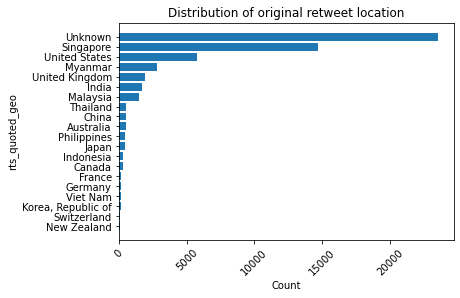

In [316]:
plot_countries_with_most_rts_creators(tweet_enagagement_retweet)

## 4. Viral local retweets: Local news feed <a id="cell4"></a>

##### Viral local retweets:Tweets created between MIN_DATE and MAX_DATE that are (1) by Singapore geocoded accounts (2) highly retweeted by count or (3) received an unusual number of endorsements - retweets and favorites


In [317]:
neg_local_retweet = tweet_enagagement_retweet[(tweet_enagagement_retweet['tweet_sentiment'] == 'negative') & \
                                                    (tweet_enagagement_retweet['retweeted_user_geo_coding'] ==  COUNTRY) & \
                                                    (tweet_enagagement_retweet['retweeted_tweet_date'].between(MIN_DATE, MAX_DATE, inclusive='both'))]

pos_local_retweet = tweet_enagagement_retweet[(tweet_enagagement_retweet['tweet_sentiment'] == 'positive') & \
                                                    (tweet_enagagement_retweet['retweeted_user_geo_coding'] ==  COUNTRY) & \
                                                    (tweet_enagagement_retweet['retweeted_tweet_date'].between(MIN_DATE, MAX_DATE, inclusive='both'))]

all_local_retweet = tweet_enagagement_retweet[(tweet_enagagement_retweet['retweeted_user_geo_coding'] ==  COUNTRY) & \
                                                    (tweet_enagagement_retweet['retweeted_tweet_date'].between(MIN_DATE, MAX_DATE, inclusive='both'))]

In [318]:
# neg_local_retweet.value_counts(subset=['retweeted_tweet_id']).reset_index(name='local_count')

In [335]:
neg_local_rts_trend_path = DATA_PATH + 'output/rts/local/neg_local_rts_trend.csv'
neg_local_rts_info_path = DATA_PATH + 'output/rts/local/neg_local_rts_info.csv'

generate_dash_bursty_retweets(neg_local_retweet, neg_local_rts_trend_path, neg_local_rts_info_path, .95)

pos_local_rts_trend_path = DATA_PATH + 'output/rts/local/pos_local_rts_trend.csv'
pos_local_rts_info_path = DATA_PATH + 'output/rts/local/pos_local_rts_info.csv'

generate_dash_bursty_retweets(pos_local_retweet, pos_local_rts_trend_path, pos_local_rts_info_path,.96)


all_local_rts_trend_path = DATA_PATH + 'output/rts/local/all_local_rts_trend.csv'
all_local_rts_info_path = DATA_PATH + 'output/rts/local/all_local_rts_info.csv'

generate_dash_bursty_retweets(all_local_retweet, all_local_rts_trend_path, all_local_rts_info_path,.96)

Total spiky tweets: 6
Alphabet Alphabet Alphabet Alphabet Alphabet  26
None
Dark24 Dark24 Dark24 Dark24 Dark24  24
None
pastel pastel pastel pastel pastel  24
None
Saved trend and info!
Total spiky tweets: 10
Alphabet Alphabet Alphabet Alphabet Alphabet  26
None
Dark24 Dark24 Dark24 Dark24 Dark24  24
None
pastel pastel pastel pastel pastel  24
None
Saved trend and info!
Total spiky tweets: 25
Alphabet Alphabet Alphabet Alphabet Alphabet  26
None
Dark24 Dark24 Dark24 Dark24 Dark24  24
None
pastel pastel pastel pastel pastel  24
None
Saved trend and info!


## 5. Viral global retweets: Global news feed <a id="cell5"></a>

Viral global retweets:Tweets created between MIN_DATE and MAX_DATE that are (1) by Non-Singapore geocoded accounts (2) highly retweeted by count or (3) received an unusual number of endorsements - retweets and favorites

In [320]:
neg_global_retweet = tweet_enagagement_retweet[(tweet_enagagement_retweet['tweet_sentiment'] == 'negative') & \
                                                    (tweet_enagagement_retweet['retweeted_user_geo_coding'] !=  COUNTRY) & \
                                                    (tweet_enagagement_retweet['retweeted_tweet_date'].between(MIN_DATE, MAX_DATE, inclusive='both'))]

pos_global_retweet = tweet_enagagement_retweet[(tweet_enagagement_retweet['tweet_sentiment'] == 'positive') & \
                                                    (tweet_enagagement_retweet['retweeted_user_geo_coding'] !=  COUNTRY) & \
                                                    (tweet_enagagement_retweet['retweeted_tweet_date'].between(MIN_DATE, MAX_DATE, inclusive='both'))]

all_global_retweet = tweet_enagagement_retweet[(tweet_enagagement_retweet['retweeted_user_geo_coding'] !=  COUNTRY) & \
                                               (tweet_enagagement_retweet['retweeted_tweet_date'].between(MIN_DATE, MAX_DATE, inclusive='both'))]

In [321]:
neg_global_rts_trend_path = DATA_PATH + 'output/rts/global/neg_global_rts_trend.csv'
neg_global_rts_info_path = DATA_PATH + 'output/rts/global/neg_global_rts_info.csv'

generate_dash_bursty_retweets(pos_global_retweet, neg_global_rts_trend_path, neg_global_rts_info_path, .95)

pos_global_rts_trend_path = DATA_PATH + 'output/rts/global/pos_global_rts_trend.csv'
pos_global_rts_info_path = DATA_PATH + 'output/rts/global/pos_global_rts_info.csv'

generate_dash_bursty_retweets(neg_global_retweet, pos_global_rts_trend_path, pos_global_rts_info_path,.96)

all_global_rts_trend_path = DATA_PATH + 'output/rts/global/all_global_rts_trend.csv'
all_global_rts_info_path = DATA_PATH + 'output/rts/global/all_global_rts_info.csv'
generate_dash_bursty_retweets(all_global_retweet, all_global_rts_trend_path, all_global_rts_info_path, .96)

Total spiky tweets: 32
Saved trend and info!
Total spiky tweets: 20
Saved trend and info!
Total spiky tweets: 71
Saved trend and info!


In [ ]:
# print("spike_value: ", spike_value)
# sub_spike = spike_df[spike_df['delta_engagement'] > spike_value]
# print("sub_spike.shape", sub_spike.shape)
# print(sub_spike.describe())
# fig = px.bar(sub_spike, y="delta_engagement")
# fig.show()

# c_neg_local_retweet[['local_count']] = c_neg_local_retweet[['local_count']].astype(int)
# sub_neg_local_retweet = c_neg_local_retweet[c_neg_local_retweet['local_count'] > 10]
# fig = px.box(sub_neg_local_retweet, y="local_count")
# fig.show()

In [218]:

#, percentile=PERCENTILE, top_tweets_count=TOP_RTS_POS_NEG):
# # count of RTs
# c_quoted = quoted_tweets.value_counts(subset=['quoted_tweet_id']).reset_index(name='local_count').sort_values('local_count', ascending=False)
# # top RTs by count
# quoted_qids_by_count = list(c_quoted[:10]['quoted_tweet_id'])

# SPIKE_THRESHOLD = 300 # TODO: Find a threshold using stats (like from outliers)
# grouped_sorted_date = quoted_tweets.groupby(['quoted_tweet_id', 'quoted_tweet_date']).apply(pd.DataFrame.sort_values, 'quoted_tweet_date').reset_index(drop=True)
# max_grouped_sorted_date = grouped_sorted_date.groupby(['quoted_tweet_id', 'quoted_tweet_date'])['total_engagement'].max().reset_index()
# max_grouped_sorted_date['delta_engagement'] = max_grouped_sorted_date.groupby(['quoted_tweet_id'])['total_engagement'].diff().fillna(0).astype(int)
# spike = max_grouped_sorted_date.groupby('quoted_tweet_id').nth(0)
# spike = list(spike[spike['delta_engagement'] > SPIKE_THRESHOLD].reset_index()['quoted_tweet_id'])

# viral_quoted_tweets = quoted_tweets[quoted_tweets['quoted_tweet_id'].isin(quoted_qids_by_count + spike)]